In [2]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
%matplotlib inline

# profile

In [ ]:
bw_scan = True

import subprocess

# name = 'HisMod_around_CTKI_peakSummit'
# capture_regions_file = '../CTKI_nanog_dome_final_summits.bed'
name = 'HisMod_around_CTKI_targetsTSS'
capture_regions_file = '../targets/CTKI_targets_TSS.bed'
resolution = 100
span = 2000
capture_points = int(2 * span / resolution + 1)
xticks = np.arange(-span, span + resolution, resolution)
bigwig_files = [
    '../../../ChIPseq/2_signal/ChIPseq_H3K27me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K36me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K4me3_dome.bw',
    '../../../ChIPseq/2_signal/ChIPseq_H3K27ac_dome_rep3.bw',
    '../../../ChIPseq/2_signal/ChIPseq_Pol2_dome_4H8.bw',
]
labels = [
    'H3K27me3',
    'H3K36me3',
    'H3K4me3',
    'H3K27ac',
    'Pol2',
]

cmd = f'''awk '{{print $1"\\t"$2-{span}-{resolution >> 1}"\\t"$3+{span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
print(subprocess.check_output(cmd, shell=True).decode(), end='')

capture_regions_file = 'capture_regions.bed'
# bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'
bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file} --strand'

for bigwig_file in bigwig_files:
    bw_scan_cmd += f' -w {bigwig_file}'

if bw_scan:
    print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')


def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


signal['CTKI'] = {}
for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
    mean = get_bigwig_mean(bigwig_file)
    signal['CTKI'][label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                sep='\t',
                                header=None,
                                index_col=None,
                                names=xticks) / mean
signal['CTKI'][labels[0]].head()

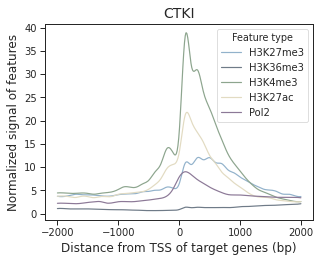

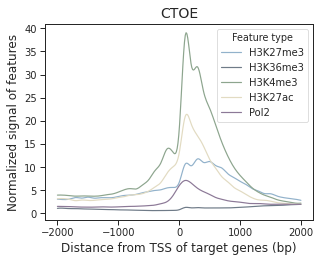

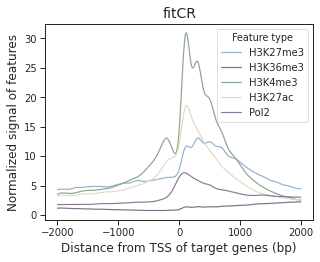

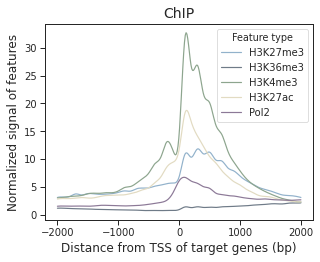

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    colors = ['#92B2CB', '#6F7B88', '#8DA58E', '#E2DBC2', '#8C7997']
    for K in signal.keys() :
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75))
        i = 0
        for label in ['H3K27me3','H3K36me3','H3K4me3','H3K27ac','Pol2']:
            x = signal[K][labels[0]].columns
            xnew = np.linspace(x.min(), x.max(), 300) 
            spl = make_interp_spline(x, signal[K][label].mean(), k = 3)
            signal_smooth = spl(xnew)
            ax.plot(xnew, signal_smooth, label=label, color=colors[i])
            i += 1
            
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, ['H3K27me3','H3K36me3','H3K4me3','H3K27ac','Pol2'], title="Feature type")
        
        ax.set_xlabel('Distance from TSS of target genes (bp)')
        ax.set_ylabel('Normalized signal of features')
        ax.set_title(K)
#         fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_line_HisModCov_{K}.pdf', transparent=True)
        fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_line_HisModCov_{K}_targetTSS.pdf', transparent=True)        

# mean

In [ ]:
bw_scan = False

import subprocess

name = 'atac_OCR_specific'
capture_regions_file = 'atac_validation/atac_wt_OCR_specific_peaks_Pou5f3.narrowPeak'
resolution = 100
span = 2000
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_pou5f3_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]

cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_atac_OCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_atac_OCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_atac_OCR_specific

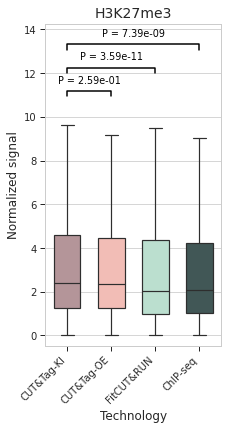

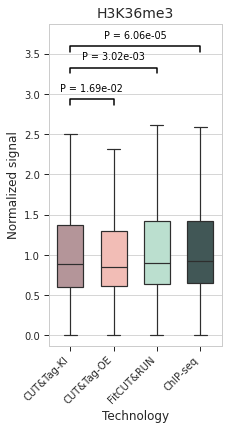

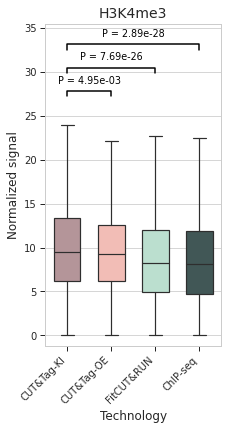

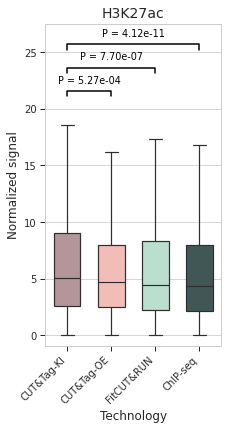

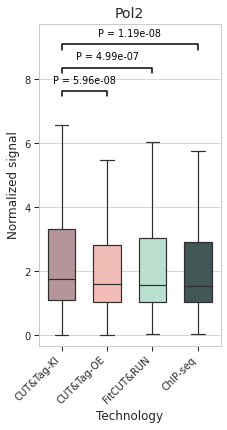

In [ ]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    for feature in signal_mean['CTKI'].columns :
        signals = signal_mean['CTKI'][feature].tolist() + signal_mean['CTOE'][feature].tolist() + signal_mean['fitCR'][feature].tolist() + signal_mean['ChIP'][feature].tolist()
        techs = ['CUT&Tag-KI'] * signal_mean['CTKI'].shape[0] + ['CUT&Tag-OE'] * signal_mean['CTOE'].shape[0] + ['FitCUT&RUN'] * signal_mean['fitCR'].shape[0] + ['ChIP-seq'] * signal_mean['ChIP'].shape[0]
        plot_pd = pd.DataFrame({'signals' : signals, 'Technology' : techs})
        fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * 1.25))
        boxplot(
            x='Technology',
            y='signals',
            data=plot_pd,
            palette=['#B99095','#FCB5AC','#B5E5CF', "#3D5B59"],
            showfliers=False,
            statistic_args={'statistic_test': 'mannwhitneyu',
                            'use_continuity': False,},
            ax=ax,
            centerCol = 0,
            width = .6
        )
        ax.set_ylabel('Normalized signal')
        ax.set_xticklabels(labels=ax.get_xticklabels(),
                           rotation=45, ha='right')
        ax.set_ylim(top = 1.25 * ax.get_ylim()[1])
        ax.set_title(feature)
        fig.tight_layout()
        fig.savefig(f'/mnt/Storage/home/wangyiman/knock_in_Sun/figures/make8_boxplot_{feature}_ov_techs_mean.pdf',
                    transparent=True)